In [1]:
import argparse
import sys
import time
import os

import numpy as np

from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from tqdm import tnrange, tqdm_notebook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import product
import copy


In [2]:
paser = argparse.ArgumentParser()
args = paser.parse_args("")
args.seed = 123
args.val_size = 0.1
args.test_size = 0.1
args.shuffle = True

In [3]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')


In [4]:
# file 이름 형태: id+object_label1,object_label2+style_label1,style_label2+material_label1,material_label2.jpg
def read_data_from_file(file_path):
  file_list = os.listdir(file_path)
  ids = []
  artwork_labels_list = [[] for _ in range(3)]

  for file_name in file_list:
    # .jpg 제거
    file_name = file_name[0: len(file_name) - 4]
    parsing_list = file_name.split('+')
    if (parsing_list[0] == ''):
        continue
    ids.append(parsing_list[0])
    del parsing_list[0]

    for i, label in enumerate(parsing_list):
        label = label.lower()
        label_list = label.split(', ')
        label_list = list(filter(None, label_list))
        artwork_labels_list[i].append(label_list)
        
  artworks = pd.DataFrame(
      {"ID": ids, "object_labels": artwork_labels_list[0], "style_labels": artwork_labels_list[1], "material_labels": artwork_labels_list[2], "File": file_list})
  artworks.dropna()
  
  return artworks


def filterLabelsByFrequency(artworks, frequency):
  for column in artworks.filter(regex='labels'):
    label_freq = artworks[column].apply(
      lambda s: [x for x in s]).explode().value_counts().sort_values(ascending=False)

    # Create a list of rare labels
    rare = list(label_freq[label_freq < frequency].index)

    artworks[column] = artworks[column].apply(
      lambda s: [x for x in s if x not in rare])
    artworks[column] = artworks[column].apply(
      lambda s: s if len(s) != 0 else np.nan)

  artworks.dropna(inplace=True)
  return artworks


   ID           object_labels                    style_labels material_labels  \
0  10  [allegorical painting]  [mannerism (late renaissance)]   [oil, canvas]   
1  11  [allegorical painting]  [mannerism (late renaissance)]     [oil, wood]   
2  12  [allegorical painting]  [mannerism (late renaissance)]   [oil, canvas]   
3  13  [allegorical painting]  [mannerism (late renaissance)]     [oil, wood]   

                                                File  
0  10+allegorical painting+Mannerism (Late Renais...  
1  11+allegorical painting+Mannerism (Late Renais...  
2  12+allegorical painting+Mannerism (Late Renais...  
3  13+allegorical painting+Mannerism (Late Renais...  


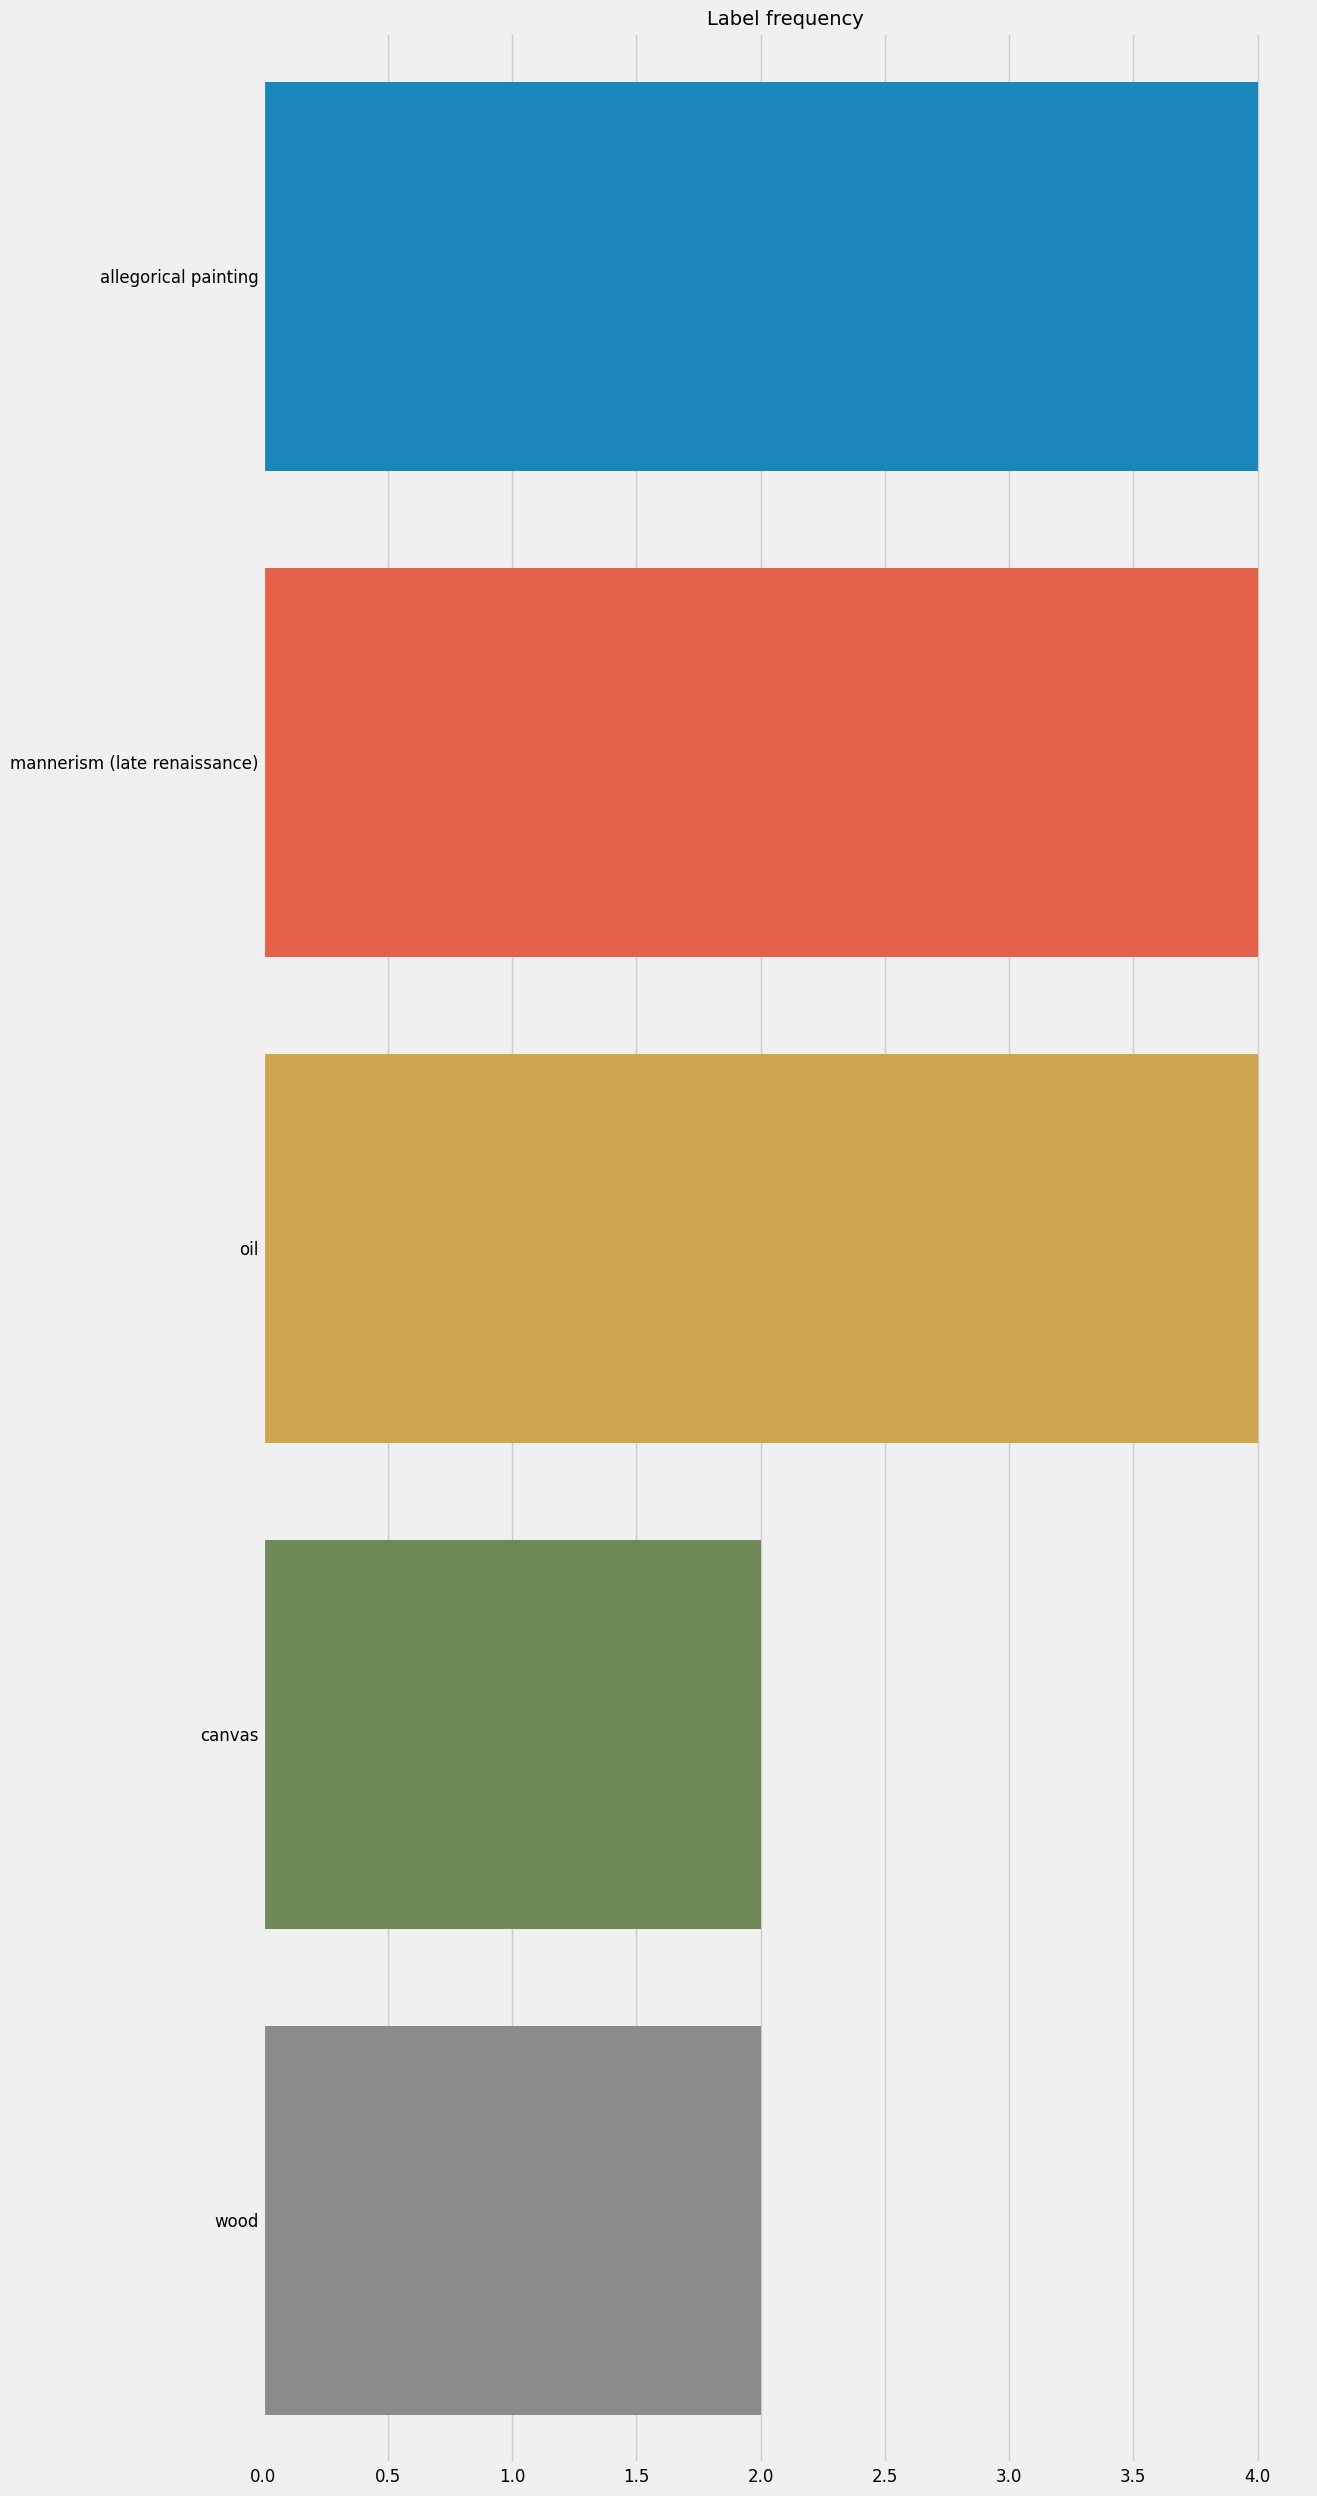

In [5]:
import matplotlib.style as style
artworks = read_data_from_file('./database_test')
artworks = filterLabelsByFrequency(artworks, 0)
print(artworks)

object_label_freq = artworks['object_labels'].apply(
    lambda s: [x for x in s]).explode().value_counts()
style_label_freq = artworks['style_labels'].apply(
    lambda s: [x for x in s]).explode().value_counts()
material_label_freq = artworks['material_labels'].apply(
    lambda s: [x for x in s]).explode().value_counts()

label_freq = pd.concat([object_label_freq, style_label_freq,
                       material_label_freq]).sort_values(ascending=False)

style.use("fivethirtyeight")
plt.figure(figsize=(12, 30))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [10]:
artworks['labels'] = artworks['object_labels'] + artworks['style_labels'] + artworks['material_labels']

dataset_size = len(artworks)
print(dataset_size)
train_size = int(dataset_size * 0.8)
validate_size = int(dataset_size * 0.1)
test_size = int(dataset_size * 0.1)


4


In [35]:
def count_labels(label_list):
    total_labels = []
    for labels in label_list:
      labels = list(filter(None, labels))
      total_labels.extend(labels)

    return len(list(set(total_labels))), list(set(total_labels))


def get_index_of_np(numpy, val):
  index_np = np.where(numpy == val)[0]

  if index_np.size != 1:
    print('a', index_np[0], index_np.size, val)
    return None
  else:
    return index_np[0]
  
def get_adjacency_matrix(artwork_labels_list, total_labels, N_LABEL):
  adjacency_matrix = np.zeros((N_LABEL, N_LABEL))
  
  for artwork_labels in artwork_labels_list:
    label_combinations = list(product(artwork_labels, repeat=2))
    
    for label_combination in label_combinations:
      pivot_index = get_index_of_np(total_labels, label_combination[0])
      target_index = get_index_of_np(total_labels, label_combination[1])
      if (pivot_index is None) or (target_index is None):
        return None
      else:
        adjacency_matrix[pivot_index][target_index] += 1

  for row_index, row in enumerate(adjacency_matrix):
    basis = row[row_index]
    for col_index, val in enumerate(row):
      row[col_index] = val/basis
    
  return adjacency_matrix


def get_feature_matrix():
  return

def convert_to_graph(artworks):
  label_classes = ['object_labels', 'style_labels', 'material_labels']
  artwork_labels_list=[]
  labels_list_by_class = [set() for _ in range(3)]

  for index, label_class in enumerate(label_classes):
    labels_group = artworks[label_class]

    if index == 0:
      for labels in labels_group:
        artwork_labels_list.append(copy.deepcopy(labels))
        labels_list_by_class[index] = labels_list_by_class[index].union(set(copy.deepcopy(labels)))
    else:
      for i, labels in enumerate(labels_group):
        artwork_labels_list[i].extend(copy.deepcopy(labels))
        labels_list_by_class[index] = labels_list_by_class[index].union(
            set(copy.deepcopy(labels)))
  
  N_LABEL, total_labels = count_labels(artwork_labels_list)
  adjacency_matrix = get_adjacency_matrix(
      artwork_labels_list, np.array(total_labels), N_LABEL)
  
  class_one_hot_encoding_matrix = np.zeros((N_LABEL, 3))

  for i in range(N_LABEL):
    label = total_labels[i]
    for j in range(3):
      class_one_hot_encoding_matrix[i][j] = np.any(
          np.array(list(labels_list_by_class[j])) == label)
  
  embedding = nn.Embedding(N_LABEL, embedding_dim=5)
  input = torch.tensor(range(len(total_labels)))
  word_embedding_matrix = embedding(input).detach().numpy()
  
  feature_matrix = np.concatenate((class_one_hot_encoding_matrix, word_embedding_matrix), axis=1)
  
  return adjacency_matrix, feature_matrix

In [36]:
adjacency_matrix, feature_matrix = convert_to_graph(artworks)
print(adjacency_matrix)

[[1.  0.5 1.  1.  0.5]
 [1.  1.  1.  1.  0. ]
 [1.  0.5 1.  1.  0.5]
 [1.  0.5 1.  1.  0.5]
 [1.  0.  1.  1.  1. ]]


In [23]:
class GCNLayer(nn.Module):
  def __init__(self, in_dim, out_dim, n_label, act=None, bn=False):
    super(GCNLayer, self).__init__()

    self.use_bn = bn
    self.linear = nn.Linear(in_dim, out_dim)
    nn.init.xavier_uniform(self.linear.weight)
    self.bn = nn.BatchNorm1d(n_label)
    self.activation = act

  def forward(self, x, adj):
    out = self.linear(x)
    out = torch.matmul(adj, out)
    if self.use_bn:
      out = self.bn(out)
    if self.activation != None:
      out = self.activation(out)

    return out, adj

In [24]:
class GatedSkipConnection(nn.Module):
  def __init__(self, in_dim, out_dim):
    super(GatedSkipConnection, self).__init__()

    self.in_dim = in_dim
    self.out_dim = out_dim

    self.linear = nn.Linear(in_dim, out_dim, bias=False)
    self.linear_coef_in = nn.Linear(out_dim, out_dim)
    self.linear_coef_out = nn.Linear(out_dim, out_dim)
    self.sigmoid = nn.Sigmoid()

  def forward(self, in_x, out_x):
    if (self.in_dim != self.out_dim):
        in_x = self.linear(in_x)
    z = self.gate_coefficient(in_x, out_x)
    out = torch.mul(z, out_x) + torch.mul(1.0-z, in_x)
    return out

  def gate_coefficient(self, in_x, out_x):
    x1 = self.linear_coef_in(in_x)
    x2 = self.linear_coef_out(out_x)
    return self.sigmoid(x1+x2)

In [25]:
class GCNBlock(nn.Module):
  def __init__(self, n_layer, in_dim, hidden_dim, out_dim, n_atom, bn=True, sc='gsc'):
    super(GCNBlock, self).__init__()

    self.layers = nn.ModuleList()
    for i in range(n_layer):
        self.layers.append(GCNLayer(in_dim if i == 0 else hidden_dim,
                                    out_dim if i == n_layer-1 else hidden_dim,
                                    n_atom,
                                    nn.ReLU() if i != n_layer-1 else None,
                                    bn))
    self.relu = nn.ReLU()
    if sc == 'gsc':
        self.sc = GatedSkipConnection(in_dim, out_dim)
    elif sc == 'no':
        self.sc = None
    else:
        assert False, "Wrong sc type."

  def forward(self, x, adj):
    residual = x
    for i, layer in enumerate(self.layers):
        out, adj = layer((x if i == 0 else out), adj)
    if self.sc != None:
        out = self.sc(residual, out)
    out = self.relu(out)
    return out, adj

In [26]:
class InceptionModule(nn.Module):
  def __init__(self, n_layer, in_dim, hidden_dim, out_dim, n_atom, bn=True, sc='gsc'):
    super(InceptionModule, self).__init__()
    self.GCNBlocks = nn.ModuleList()
    for i in range(n_layer):
      self.GCNBlocks.append(GCNBlock(i,
                                    in_dim,
                                    hidden_dim,
                                    out_dim))
  def forward(self, x, adj):
    outs = []
    for i, block in enumerate(self.GCNBlocks):
      outs.append(block(x, adj))

    feature_concatenate = torch.cat(outs, 2)
    return feature_concatenate, adj

In [27]:
class ReadOut(nn.Module):

    def __init__(self, in_dim, out_dim, act=None):
        super(ReadOut, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim

        self.linear = nn.Linear(self.in_dim,
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act

    def forward(self, x):
        out = self.linear(x)
        out = torch.sum(out, 1)
        if self.activation != None:
            out = self.activation(out)
        return out

In [ ]:
class GCNNet(nn.Module):
  def __init__(self, args):
    super(GCNNet, self).__init__()


In [ ]:
class CNNLayer(nn.Module):
  def __init__(self):
    super(CNNLayer, self).__init__()